## 随机森林在数据上的调参

用基于方差和偏差的调参方法，在乳腺癌数据上进行一次随机森林的调参。乳腺癌数据是sklearn自带的分类数据之一。

案例中，往往使用真实数据，为什么我们要使用sklearn自带的数据呢？因为真实数据在随机森林下的调参过程，往往非常缓慢。真实数据量大，维度高，在使用随机森林之前需要一系列的处理，因此不太适合用来做直播中的案例演示。原本，我为大家准备了kaggle上下载的辨别手写数字的数据，有4W多条记录700多个左右的特征，随机森林在这个辨别手写数字的数据上有非常好的表现，其调参案例也是非常经典，但是由于数据的维度太高，太过复杂，运行一次完整的网格搜索需要四五个小时，因此不太可能拿来给大家进行演示。经典的泰坦尼克号数据，用来调参的话也是需要很长时间，因此我才选择sklearn当中自带的，结构相对清晰简单的数据来为大家做这个案例。大家感兴趣的话，可以直接到kaggle上进行下载，数据集名称是Digit Recognizer（https://www.kaggle.com/c/digit-recognizer）。

In [22]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [23]:
data = load_breast_cancer()

先进行一次简单的建模，看看模型本身在数据集上的效果

In [24]:
rfc = RandomForestClassifier(n_estimators=100,random_state=90)
score_pre = cross_val_score(rfc,data.data,data.target,cv=10).mean()
score_pre

0.9648809523809524

1.调参第一步：无论如何先来调n_estimators

0.9648809523809524 66


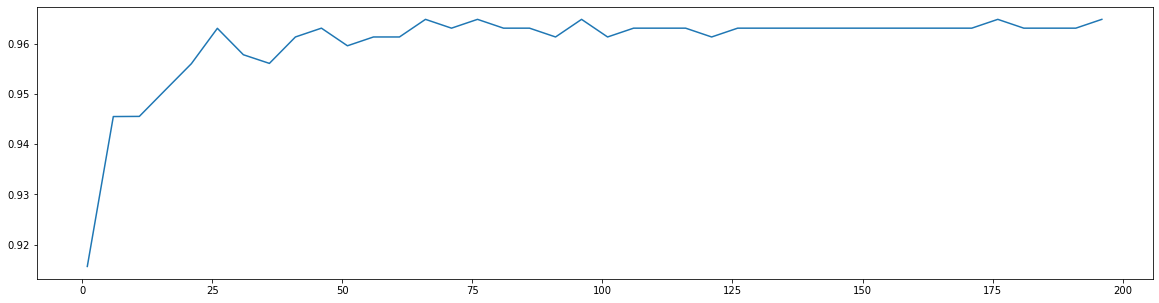

In [26]:
# 这里选择学习曲线,可以使用网格搜索,但只有学习曲线才能看见趋势
# 要看见n_estimators在什么取值下变得平稳,是否一直推动模型整体准确率的上升等信息
# 第一次的学习曲线,可以帮助我们划定范围,取每10个数作为一个阶段,来观察n_estimators的变化如何引起模型整体准确率的变化
scorel = []
for i in range(0,200,5):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,data.data,data.target,cv=10).mean()
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*5)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,5),scorel)
plt.show()
#list.index([object])，返回这个object在列表list中的索引

2.调参第二步：细化学习曲线   
　　在确定好的范围内，进一步细化学习曲线

0.9666353383458647 73


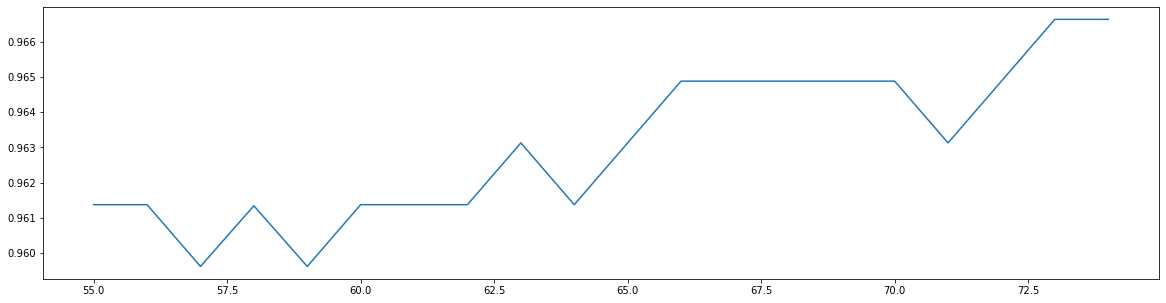

In [28]:
scorel = []
for i in range(55,75):
    rfc = RandomForestClassifier(n_estimators=i,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,data.data,data.target,cv=10).mean()
    scorel.append(score)
print(max(scorel),([*range(55,75)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(55,75),scorel)
plt.show()

接下来就进入网格搜索，我们将使用网格搜索对参数一个个进行调整。为什么我们不同时调整多个参数呢？原因有两个：1）同时调整多个参数会运行非常缓慢，在课堂上我们没有这么多的时间。2）同时调整多个参数，会让我们无法理解参数的组合是怎么得来的，所以即便网格搜索调出来的结果不好，我们也不知道从哪里去改。在这里，为了使用复杂度-泛化误差方法（方差-偏差方法），我们对参数进行一个个地调整。

3.书写网格搜索的参数

有一些参数是没有参照的，很难说清一个范围，这种情况下我们使用学习曲线，看趋势 从曲线跑出的结果中选取一个更小的区间，再跑曲线

In [ ]:
param_grid = {'n_estimators':np.arange(0, 200, 10)}
param_grid = {'max_depth':np.arange(1, 20, 1)}
param_grid = {'max_leaf_nodes':np.arange(25,50,1)}
#对于大型数据集，可以尝试从1000来构建，先输入1000，每100个叶子一个区间，再逐渐缩小范围
# 有一些参数是可以找到一个范围的，或者说我们知道他们的取值和随着他们的取值，模型的整体准确率会如何变化，这样的参数我们就可以直接跑网格搜索
param_grid = {'criterion':['gini', 'entropy']}
param_grid = {'min_samples_split':np.arange(2, 2+20, 1)}
param_grid = {'min_samples_leaf':np.arange(1, 1+10, 1)}
param_grid = {'max_features':np.arange(5,30,1)}

4.调整max_depth    
　　开始按照参数对模型整体准确率的影响程度进行调参，首先调整max_depth

In [19]:
#调整max_depth
param_grid = {'max_depth':np.arange(1, 20, 1)}
#   一般根据数据的大小来进行一个试探，乳腺癌数据很小，所以可以采用1~10，或者1~20这样的试探
#   但对于像digit recognition那样的大型数据来说，我们应该尝试30~50层深度（或许还不足够
#   更应该画出学习曲线，来观察深度对模型的影响
rfc = RandomForestClassifier(n_estimators=73
                             ,random_state=90
                            )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=73, random_state=90),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [20]:
GS.best_params_  #  显示调整出来的最佳参数

{'max_depth': 8}

In [21]:
GS.best_score_   # 返回调整好的最佳参数对应的准确率

0.9666353383458647

在这里，我们注意到，**将max_depth设置为有限之后，模型的准确率下降了。** 限制max_depth，是让模型变得简单，把模型向左推，而模型整体的准确率下降了，即整体的泛化误差上升了，这**说明模型现在位于图像左边，即泛化误差最低点的左边（偏差为主导的一边）。** 通常来说，随机森林应该在泛化误差最低点的右边，树模型应该倾向于过拟合，而不是拟合不足。这和数据集本身有关，但也有可能是我们调整的n_estimators对于数据集来说太大，因此将模型拉到泛化误差最低点去了。然而，既然我们追求最低泛化误差，那我们就保留这个n_estimators，除非有其他的因素，可以帮助我们达到更高的准确率。

当模型位于图像左边时，我们需要的是增加模型复杂度（增加方差，减少偏差）的选项，因此max_depth应该尽量大，min_samples_leaf和min_samples_split都应该尽量小。这几乎是在说明，除了**max_features**， 我们没有任何参数可以调整了，**因为max_depth，min_samples_leaf和min_samples_split是剪枝参数，是减小复杂度的参数。**   

在这里，我们**可以预言，我们已经非常接近模型的上限，模型很可能没有办法再进步了。**

那我们这就来调整一下max_features，看看模型如何变化。

5.调整max_features

In [29]:
#调整max_features
param_grid = {'max_features':np.arange(5,30,1)}
rfc = RandomForestClassifier(n_estimators=73
                             ,random_state=90
                            )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=73, random_state=90),
             param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29])})

In [30]:
GS.best_params_

{'max_features': 24}

In [31]:
GS.best_score_  # 此处泛化误差是减小的

0.9666666666666668

原:   
网格搜索返回了max_features的最小值，可见max_features升高之后，模型的准确率降低了。这说明，我们把模型往右推，模型的泛化误差增加了。前面用max_depth往左推，现在用max_features往右推，泛化误差都增加，这说明模型本身已经处于泛化误差最低点，已经达到了模型的预测上限，没有参数可以左右的部分了。**剩下的那些误差，是噪声决定的，已经没有方差和偏差的舞台了。**

如果是现实案例，我们到这一步其实就可以停下了，因为复杂度和泛化误差的关系已经告诉我们，模型不能再进步了。调参和训练模型都需要很长的时间，明知道模型不能进步了还继续调整，不是一个有效率的做法。如果我们希望模型更进一步，我们会选择更换算法，或者更换做数据预处理的方式。但是在课上，出于练习和探索的目的，我们继续调整我们的参数，让大家观察一下模型的变化，看看我们预测得是否正确。

依然按照参数对模型整体准确率的影响程度进行调参。

6.调整min_samples_leaf

对于min_samples_split和min_samples_leaf,一般是从他们的最小值开始向上增加10或20 面对高维度高样本量数据，如果不放心，也可以直接+50，对于大型数据，可能需要200~300的范围 如果调整的时候发现准确率无论如何都上不来，那可以放心大胆调一个很大的数据，大力限制模型的复杂度

In [32]:
#调整min_samples_leaf
param_grid={'min_samples_leaf':np.arange(1, 1+10, 1)}
rfc = RandomForestClassifier(n_estimators=73
                             ,random_state=90
                            )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=73, random_state=90),
             param_grid={'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [33]:
GS.best_params_   # 泛化误差不能向左调整,所以必然是1

{'min_samples_leaf': 1}

In [34]:
GS.best_score_

0.9666353383458647

可以看见，网格搜索返回了min_samples_leaf的最小值，并且模型整体的准确率还降低了，这和max_depth的情况一致，参数把模型向左推，但是模型的泛化误差上升了。在这种情况下，我们显然是不要把这个参数设置起来的，就让它默认就好了。

7.调整min_samples_split

In [35]:
#调整min_samples_split
param_grid={'min_samples_split':np.arange(2, 2+20, 1)}
rfc = RandomForestClassifier(n_estimators=73
                             ,random_state=90
                            )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=73, random_state=90),
             param_grid={'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21])})

In [36]:
GS.best_params_

{'min_samples_split': 2}

In [37]:
GS.best_score_

0.9666353383458647

和min_samples_leaf一样的结果，返回最小值并且模型整体的准确率降低了。

8.调整criterion   
criterion 无法预知会对模型造成什么样的变化

In [38]:
#调整Criterion
param_grid = {'criterion':['gini', 'entropy']}
rfc = RandomForestClassifier(n_estimators=73
                             ,random_state=90
                            )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=73, random_state=90),
             param_grid={'criterion': ['gini', 'entropy']})

In [39]:
GS.best_params_

{'criterion': 'gini'}

In [40]:
GS.best_score_

0.9666353383458647

In [ ]:
# 合并起来调整单个最佳并不是全局最佳,但会在其附近

In [43]:
param_grid = {'max_features':np.arange(22,26,1)  # 单个最好 24
             ,'max_depth':np.arange(6, 10, 1)  # 单个最好 8
             ,'n_estimators':np.arange(70, 75, 1)}   # 单个最好 73
rfc = RandomForestClassifier(random_state=90
                            )
GS = GridSearchCV(rfc,param_grid,cv=10)
GS.fit(data.data,data.target)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=90),
             param_grid={'max_depth': array([6, 7, 8, 9]),
                         'max_features': array([22, 23, 24, 25]),
                         'n_estimators': array([70, 71, 72, 73, 74])})

In [44]:
GS.best_params_

{'max_depth': 8, 'max_features': 22, 'n_estimators': 71}

In [45]:
GS.best_score_

0.968421052631579

In [46]:
GS.best_score_-score_pre  # 增加了0.3%

0.0035401002506265655

9.总结最佳参数    
调整完毕，总结出模型的最佳参数

In [47]:
rfc = RandomForestClassifier(n_estimators=71,max_features=22,max_depth=8,random_state=90)
score = cross_val_score(rfc,data.data,data.target,cv=10).mean()
score - score_pre   # 调参增加的分数

0.0035401002506265655

在整个调参过程之中，我们首先调整了n_estimators（无论如何都请先走这一步），然后调整max_depth，通过max_depth产生的结果，来判断模型位于复杂度-泛化误差图像的哪一边，从而选择我们应该调整的参数和调参的方向。如果感到困惑，也可以画很多学习曲线来观察参数会如何影响我们的准确率，选取学习曲线中单调的部分来放大研究（如同我们对n_estimators做的）。学习曲线的拐点也许就是我们一直在追求的，最佳复杂度对应的泛化误差最低点（也是方差和偏差的平衡点）。

网格搜索也可以一起调整多个参数，大家只要有时间，可以自己跑一下，看看网格搜索会给我们怎样的结果，有时候，它的结果比我们的好，有时候，我们手动调整的结果会比较好。当然了，我们的乳腺癌数据集非常完美，所以只需要调n_estimators一个参数就达到了随机森林在这个数据集上表现得极限。在我们上周使用的泰坦尼克号案例的数据中，我们使用同样的方法调出了如下的参数组合。